In [1]:
import os
import shutil
import time
from datetime import timedelta
from importlib import reload
from pathlib import Path
from functools import partial

import numpy as np
import tensorflow as tf
from IPython.display import display, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import solver; reload(solver)
import initializers; reload(initializers)
import plotter; reload(plotter)
import helpers

%pylab inline

Populating the interactive namespace from numpy and matplotlib


2021-12-03 02:35:03.617086: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# some directories definition
base_dir = '/Users/IllarionK/Projects/master_degree'
if not os.path.exists(base_dir):
    base_dir = '/src'
frames_dir = os.path.join(base_dir, 'frames')
os.makedirs(frames_dir, exist_ok=True)
video_dir = os.path.join(base_dir, 'videos')
os.makedirs(video_dir, exist_ok=True)

## Variables definition

In [127]:
SECONDS_TO_SIMULATE = 100
NORM_LENGTH = 1
NORM_LENGTH_X = NORM_LENGTH * 4
NORM_LENGTH_Y = NORM_LENGTH * 2
SCALE = 100
LENGTH_X  = NORM_LENGTH_X * SCALE
LENGTH_Y  = NORM_LENGTH_Y * SCALE
N_STEPS = SECONDS_TO_SIMULATE * SCALE

### Object parameters
OBJ_CENTER_X = LENGTH_X / 4
OBJ_CENTER_Y = LENGTH_Y / 2
# X.shape: (LENGTH_Y, LENGTH_X) Y shape: (LENGTH_Y, LENGTH_X)
X_MESH, Y_MESH = np.meshgrid(range(LENGTH_X), range(LENGTH_Y))
# INFO: shape the same as all space, but only partially filled with object
shape_kwargs = {
    "x_mesh": X_MESH,
    "y_mesh": Y_MESH,
    "obj_center_x": OBJ_CENTER_X,
    "obj_center_y": OBJ_CENTER_Y,
    "scale": SCALE
}
SHAPE = 'CYLINDER'
if SHAPE == 'SQUARE':
    # TODO: only select function here, define partial outside of if statement
    OBJ_D = 0.1
    obj_mask_init = partial(
        initializers.get_square,
        obj_d=OBJ_D,
        **shape_kwargs
    )
elif SHAPE == 'CYLINDER':
    OBJ_D = 0.125 * 2
    obj_mask_init = partial(
        initializers.get_cylinder,
        obj_d=OBJ_D,
        **shape_kwargs
    )
elif shape == 'PLATE':
    OBJ_D = 0.1
    obj_mask_init = partial(
        initializers.get_plate,
        obj_d=OBJ_D,
        **shape_kwargs
    )
OBJECT_MASK = obj_mask_init(y_shift=0)

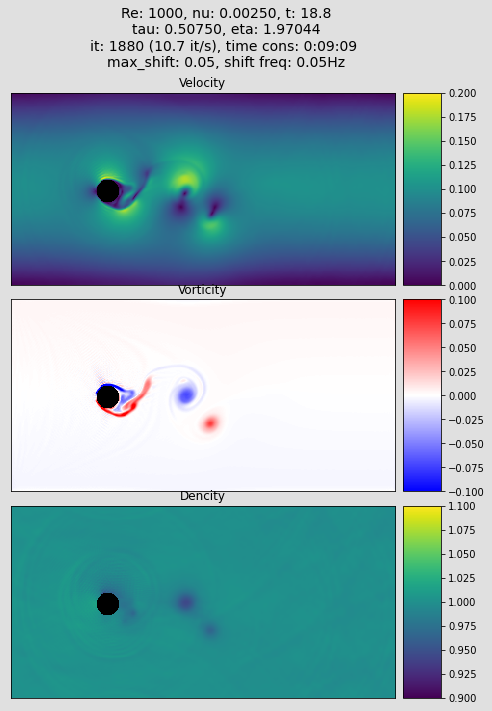

In [ ]:
def prep_figure():
    fig, axes = plt.subplots(3, figsize=FIGSIZE)
    fig.patch.set_facecolor('#E0E0E0')
    for ax in axes:
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
    return fig, axes

bwr_cmap = plt.cm.bwr.copy()
bwr_cmap.set_bad('black')
viridis_cmap = plt.cm.viridis.copy()
viridis_cmap.set_bad('black')


REs = [10, 60, 100, 200, 500, 1000][::-1]
# REs = [500]
PLOT = False
SAVE_RES = True
FIGSIZE = (10, 10)
vorticities = []
for RE in REs:
    for MAX_SHIFT in [0.05, 0.1, 0.2]:
        for SHIFT_FREQ in [1/20, 1/10, 1/5]:
        #     MAX_SHIFT = 0.1
        #     SHIFT_FREQ = 1 / 10  # Hz
            nu, tau, omega = initializers.calc_init_params(
                scale=SCALE,
                Re=RE,
                D=OBJ_D,
            )
            print(f"nu: {nu}")
            print(f"tau: {tau}")
            print(f"omega: {omega:.5f}")

            if PLOT:
                fig, axes = prep_figure()
            if SAVE_RES:
                res_frame_dir = os.path.join(
                    frames_dir + f'_{SHAPE}',
                    f"re-{RE}_scale-{SCALE}_mshift-{MAX_SHIFT}_freq-{SHIFT_FREQ}")
                if os.path.exists(res_frame_dir):
                    shutil.rmtree(res_frame_dir)
                Path(res_frame_dir).mkdir(exist_ok=True, parents=True)

            F = initializers.init_poiseuille(
                length_x=LENGTH_X,
                length_y=LENGTH_Y
            )
            first_col = np.copy(F[:, 0, :])
            last_col = np.copy(F[:, -1, :])
            wide_F = np.zeros((F.shape[0] + 2, F.shape[1] + 2, 9))
            start = time.time()
            global_start_time = time.time()

            first_step = True
            update_freq = MAX_SHIFT * SCALE * 4 * SHIFT_FREQ
            cbars = []
            for it in tqdm(range(N_STEPS), disable=(PLOT or SAVE_RES)):
                sec = it / SCALE
                shift_step = int(sec * 100) // int(100 * 1 / update_freq)
                y_shift = helpers.get_shift_from_step(step=shift_step, max_shift=int(MAX_SHIFT * SCALE))
                object_mask = obj_mask_init(y_shift=y_shift)
                F = solver.calc(
                    F, wide_F,
                    obj_mask_np=object_mask.astype(np.uint8),
                    tau=tau,
                )
                # TODO: move this inside calculation method
                # TODO: or fix copied columns at the wide_F
                F[:, 0, :] = first_col
                F[:, -1, :] = last_col

                # plot each 0.1 sec
                dip_it = int(0.1 * SCALE)
                if (it % dip_it == 0 or it == N_STEPS - 1) and (PLOT or SAVE_RES):
                    end = time.time()
                    plot_it_per_sec = dip_it / (end - start)
                    start = end
                    time_cons = str(timedelta(seconds=time.time() - global_start_time)).split(".")[0]
                    if SAVE_RES:
                        fig, axes = prep_figure()
                    plot_results = plotter.pre_plot(F)
                    titles = ['Velocity', 'Vorticity', 'Dencity']
                    cmaps = [viridis_cmap, bwr_cmap, viridis_cmap]

                    u, vorticity, rho = plot_results
                    vorticities.append(np.copy(vorticity))

                    suptitle_text = (
                            f"Re: {RE}, nu: {nu:.5f}, t: {sec:.1f}"
                            f"\ntau: {tau:.5f}, eta: {1 / tau:.5f}"
                            f"\nit: {it} ({plot_it_per_sec:.1f} it/s), time cons: {time_cons} "
                        )
                    if MAX_SHIFT:
                        suptitle_text += f"\nmax_shift: {MAX_SHIFT}, shift freq: {SHIFT_FREQ}Hz\n"
                    fig.suptitle(suptitle_text, fontsize=14)
                    fig.tight_layout()
                    for idx, ax, title, img, cmap in zip([0, 1, 2], axes, titles, plot_results, cmaps):
                        ax.cla()
                        ax.set_title(f"{title}")
                        img[object_mask] = None
                        plot_defaults = {
                            'aspect': 'equal',
                            'interpolation': 'none',
                        }
                        title_to_norm = {
                            'Velocity': matplotlib.pyplot.Normalize(0, .2),
                            'Vorticity': matplotlib.pyplot.Normalize(-.1, .1),
                            'Dencity': matplotlib.pyplot.Normalize(1.1, .9)
                        }
                        diplayed_im = ax.imshow(img, cmap=cmap, norm=title_to_norm[title], **plot_defaults)

                        if first_step or SAVE_RES:
                            divider = make_axes_locatable(ax)
                            cax = divider.append_axes('right', size='10%', pad="2%")
                            cbars.append(fig.colorbar(diplayed_im, cax=cax, orientation='vertical'))
                        else:
                            cbars[idx].vmin=img.min()
                            cbars[idx].vmax=img.max()
                            cbars[idx].update_normal(diplayed_im)
                    first_step = False

                    if PLOT:
                        display(fig)
                    clear_output(wait=True)
                    if SAVE_RES:
                        pylab.savefig(
                            os.path.join(res_frame_dir, str(it)),
                            facecolor=fig.get_facecolor(),
                            transparent=False
                        )
                    plt.pause(0.001)
